In [1]:
import json
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.utils.data
from skimage import io
from torch.utils.data import DataLoader

from intelligent_placer_lib.dataset.wrapper import FiniteWrapperDataset
from intelligent_placer_lib.dataset.placer import PlacerRealDataset
from intelligent_placer_lib.model.placer import PlacerPL

In [2]:
def make_contours():
    object_masks = []

    for i, img_path in enumerate(Path('data/').glob('*.jpg')):
        json_path = Path(img_path.parent) / (img_path.stem + '.json')

        img = io.imread(img_path)

        with open(json_path, 'r') as f:
            data = json.load(f)
        polygon_coords = np.array(data['shapes'][0]['points'], dtype=np.int32)

        mask = cv2.fillPoly(np.zeros(img.shape[:2]), [polygon_coords], 1)

        bbox = np.array([np.min(polygon_coords[:, 0]), np.min(polygon_coords[:, 1]),
                         np.max(polygon_coords[:, 0]), np.max(polygon_coords[:, 1])], dtype=np.int32)

        object_masks.append(np.int32(mask)[bbox[1]: bbox[3], bbox[0]: bbox[2]])

    contours = []

    for mask in object_masks:
        contour = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = cv2.convexHull(contour[0][0])[:, 0] // 2
        contours.append(contour)

    return contours

In [3]:
contours = make_contours()
# ds = PlacerRandomDataset(8, 10, 35, 85, 128, (44, 84))
# ds = FiniteWrapperDataset(PlacerDoableDataset(10, 85, (44, 84), 128), 10000)
ds = FiniteWrapperDataset(PlacerRealDataset(contours, 256), 10000)

loader = DataLoader(ds, batch_size=20)

In [5]:
net = PlacerPL()
trainer = pl.Trainer(max_epochs=200, accumulate_grad_batches=100000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
trainer.fit(model=net, train_dataloaders=loader, ckpt_path='C:/Users/Aleksandr_Timofeev2/Downloads/placer (1).checkpoint')

Restoring states from the checkpoint path at C:/Users/Aleksandr_Timofeev2/Downloads/placer (1).checkpoint
c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:250: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start from the beginning of the next epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint.
  rank_zero_warn(
Restored all states from the checkpoint file at C:/Users/Aleksandr_Timofeev2/Downloads/placer (1).checkpoint

  | Name  | Type         | Params
---------------------------------------
0 | model | PlacerResnet | 23.5 M
---------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.118    Total estimated model params size (MB)
c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\pytorch_lightning\trainer\dat

Training: 0it [00:00, ?it/s]

c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
def to_rgb(x, i):
    return np.concatenate([np.zeros([*x.shape, i]), x[..., np.newaxis], np.zeros([*x.shape, 2-i])], axis=-1)

c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\torch\nn\functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\torch\nn\functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


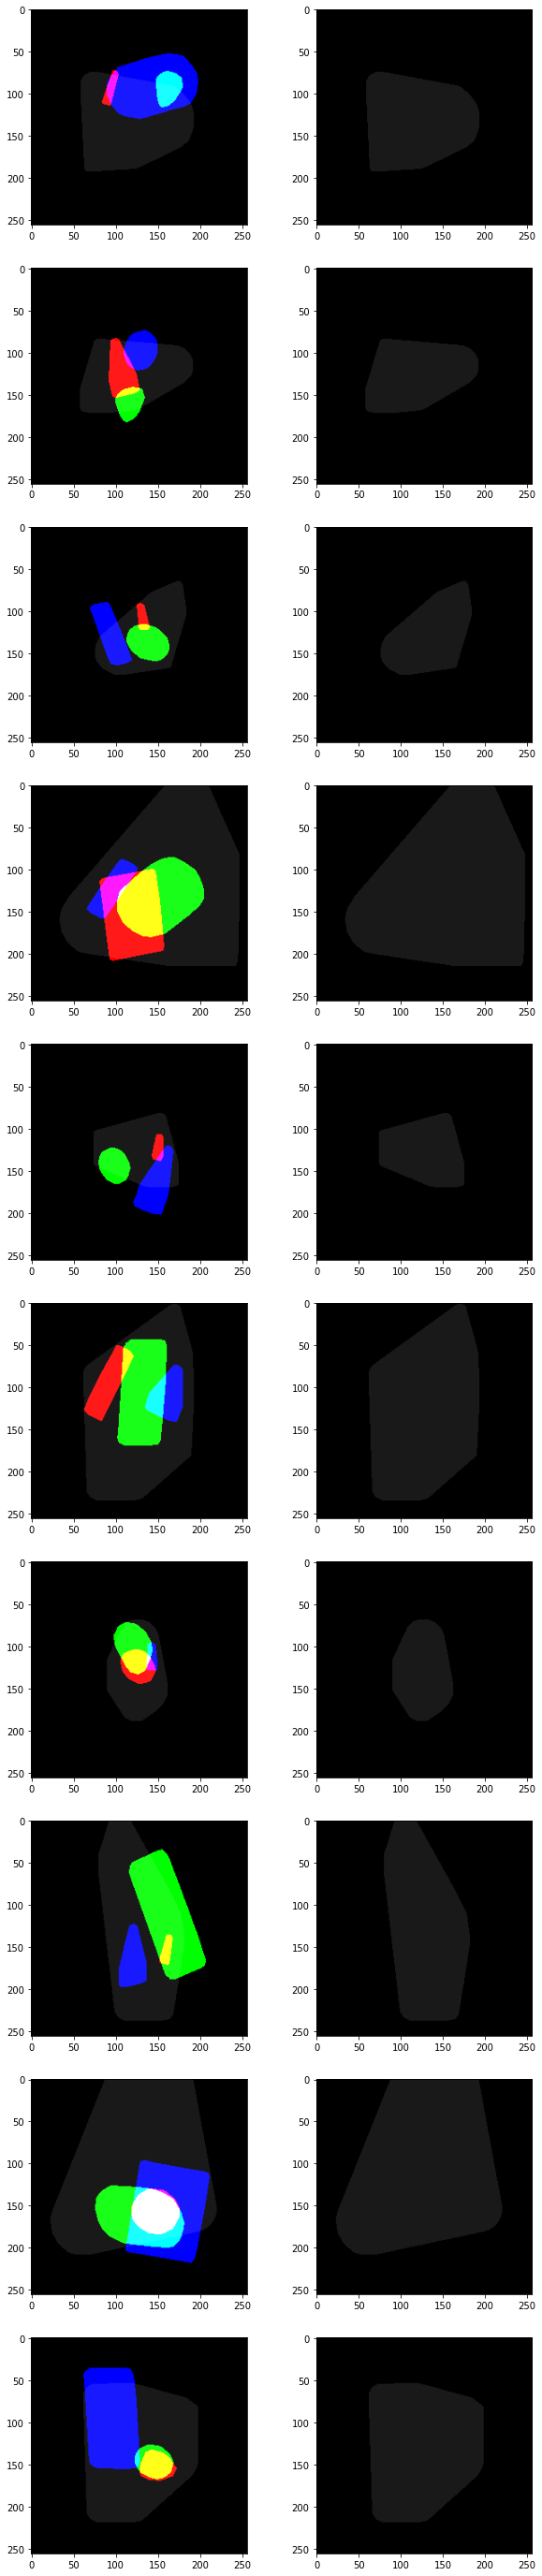

In [6]:
fig, ax = plt.subplots(10, 2, figsize=(10, 5 * 10))

num_rot = 3

for i in range(10):
    x_rect, y_rect, means = next(iter(ds))

    x_rect_tr, means = net.model.eval()(torch.tensor(x_rect[np.newaxis, ...]), torch.tensor(y_rect[np.newaxis, ...]), torch.tensor(means[np.newaxis, ...]))
    x_rect_tr = x_rect_tr[0].detach().numpy()

    image = np.zeros((*x_rect.shape[1:], 3))
    image[:, :] += y_rect[0, :, :, np.newaxis] * 0.1
    image = np.maximum(image, np.moveaxis(x_rect, 0, -1))

    ax[i][0].imshow(image)

    image = np.zeros((*x_rect_tr.shape[1:], 3))
    image[:, :] += y_rect[0, :, :, np.newaxis] * 0.1
    image = np.maximum(image, np.moveaxis(x_rect_tr, 0, -1))

    ax[i][1].imshow(image)

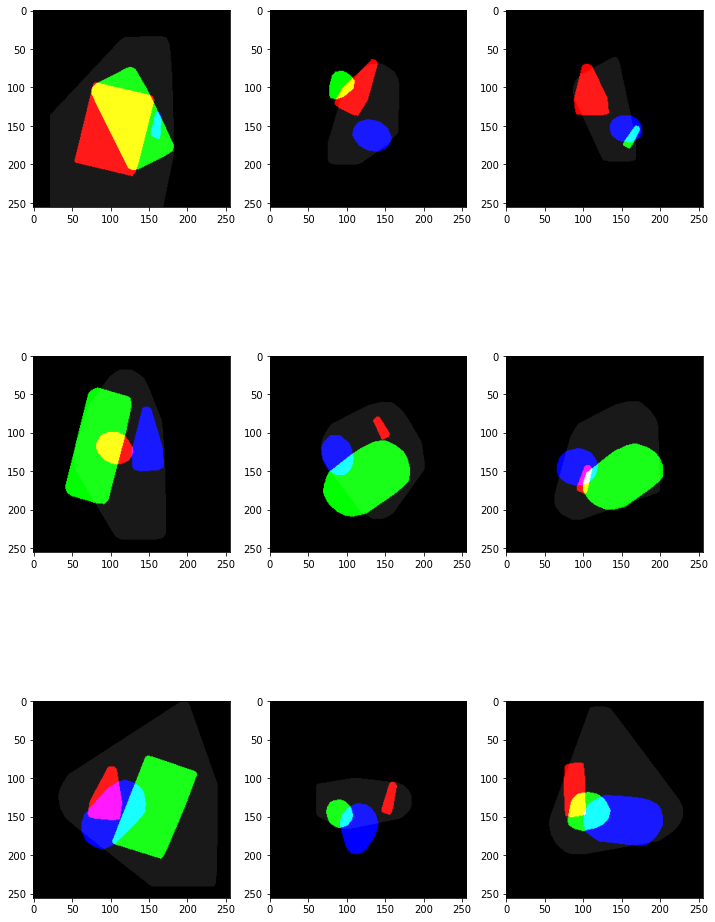

In [11]:
ncols = 3
nrows = 3

fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))

for i in range(ncols * nrows):
    x_rect, y_rect, _ = next(iter(ds))

    image = np.zeros((*x_rect.shape[1:], 3))
    image[:, :] += y_rect[0, :, :, np.newaxis] * 0.1
    image = np.maximum(image, np.moveaxis(x_rect, 0, -1))

    ax.flatten()[i].imshow(image)

In [9]:
torch.save(net.model.state_dict(), 'placer_weights.pth')

In [8]:
trainer.optimizers

[Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 5e-05
     maximize: False
     weight_decay: 0
 )]